In [7]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from sound_utils import *
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_rms(waveforms):
    reshape=False
    if len(waveforms.shape) == 4:
        waveforms = waveforms.reshape(-1, 16, 1056)
        reshape = True
    result = waveforms.square().mean(axis=len(waveforms.shape) - 1).sqrt()
    if reshape:
        return result.reshape(-1, 4, 4)
    return result

def get_max_rms(rms_waveforms):
    return rms_waveforms.max(axis=1)[0]

node_angles = torch.tensor([-170.0733866, 78.6594006, 28.185428, -133.0562463])
node_positions = torch.tensor([[610, 199], [233, 13], [13, 117], [491, 393]])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
combined_waveforms, combined_positions= torch.load("final_results/truck_final_combined_data.pt")
# test_set_bins=torch.load("final_results/test_set_bins.pt")
rms_waveforms = calculate_rms(combined_waveforms)

In [3]:
p = print

In [5]:
p(combined_waveforms.shape, combined_positions.shape)
# p(torch.cat(test_set_bins).shape, combined_positions.shape)


torch.Size([5764, 4, 4, 1056]) torch.Size([5764, 2])


In [45]:
p(rms_waveforms.shape)
def predict_waveform_angles(waveforms, gcc_phat_method=True):
    angles = torch.zeros(len(waveforms), 4)
    for data in tqdm(range(len(waveforms))):
        for node in range(4):
            node_waveforms = waveforms[data, node]
            angle = predict_angle(node_waveforms, gcc_phat_method=gcc_phat_method) + node_angles[node]
            angles[data, node] = angle % 360
    return angles

torch.Size([5764, 4, 4])


In [46]:
def angle_diff(a1, a2):
    return min(torch.abs((a1 - a2) % 360), torch.abs(a1 + 360 - a2), torch.abs(a1 - 360 - a2))

def calculate_position_angles(positions):
    angles = torch.zeros(len(positions), 4)
    for data_idx in tqdm(range(len(positions))):
        for node_idx in range(4):
            position_diff = positions[data_idx] - node_positions[node_idx]
            angle = torch.atan(position_diff[1]/position_diff[0]) * 180.0 / torch.pi
            if position_diff[0] < 0:
                angle += 180
            angle = angle % 360
            angles[data_idx, node_idx] = angle
    return angles

def calculate_angle_error(waveforms, positions, gcc_phat_method=True):
    angles1 = predict_waveform_angles(waveforms, gcc_phat_method=gcc_phat_method)
    angles2 = calculate_position_angles(positions)
    
    
    
print()
print(calculate_position_angles(combined_positions[:5]))

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1506.57it/s]

tensor([[206.0770,  26.3679,   1.7083, 265.4922],
        [204.5155,  27.3466,   1.9140, 263.9158],
        [202.9021,  28.4683,   2.1992, 262.3434],
        [201.2573,  29.7191,   2.5602, 260.7812],
        [199.5704,  31.0954,   3.0085, 259.2513]])


In [3]:
# angles1 = predict_waveform_angles(combined_waveforms, gcc_phat_method=True)
# angles2 = predict_waveform_angles(combined_waveforms, gcc_phat_method=False)
# angles3 = calculate_position_angles(combined_positions)
# print(angles1, angles2, angles3)
# torch.save((angles1, angles2, angles3), "final_results/combined_angle_data.pt")
angles1, angles2, angles3 = torch.load("final_results/combined_angle_data.pt")
print(angles1, angles2, angles3)

tensor([[195.9266,  28.6594,   8.1854, 265.9438],
        [197.9266,  28.6594,  17.1854, 263.9438],
        [197.9266,  60.6594,  18.1854, 263.9438],
        ...,
        [185.9266, 107.6594,  67.1854, 194.9438],
        [185.9266, 107.6594,  67.1854, 197.9438],
        [185.9266, 157.6594,  63.1854, 197.9438]]) tensor([[202.9266,  25.6594, 338.1854, 268.9438],
        [199.9266,  25.6594, 348.1854, 266.9438],
        [199.9266,  47.6594,   8.1854, 266.9438],
        ...,
        [215.9266, 137.6594,  88.1854, 195.9438],
        [185.9266, 137.6594,  81.1854, 200.9438],
        [185.9266, 172.6594,  62.1854, 200.9438]]) tensor([[206.0770,  26.3679,   1.7083, 265.4922],
        [204.5155,  27.3466,   1.9140, 263.9158],
        [202.9021,  28.4683,   2.1992, 262.3434],
        ...,
        [176.9356, 125.0605,  57.7106, 202.0949],
        [177.4251, 125.6577,  56.6658, 202.6302],
        [177.9006, 126.1854,  55.4365, 203.1670]])


In [4]:
def angle_diff(a1, a2):
    return min(torch.abs((a1 - a2) % 360), torch.abs((a2 - a1) % 360), torch.abs(a1 + 360 - a2), torch.abs(a1 - 360 - a2))
angle_diff(torch.tensor(56), torch.tensor(57))

tensor(1)

In [5]:
angles13 = torch.zeros(angles1.shape)
for i in range(len(angles1)):
    for j in range(4):
        angles13[i, j] = angle_diff(angles1[i, j], angles3[i, j])

angles23 = torch.zeros(angles2.shape)
for i in range(len(angles2)):
    for j in range(4):
        angles23[i, j] = angle_diff(angles2[i, j], angles3[i, j])
        if angles23[i, j] > 180:
            print(angles2[i, j], angles3[i, j])
        

tensor(13.3074)
tensor(11.2599)
tensor(10.3004)
tensor(11.3875)
tensor(10.9954)
tensor(11.6035)
tensor(10.4476)
tensor(12.9332)
tensor(20.3999)
tensor(51.2603)


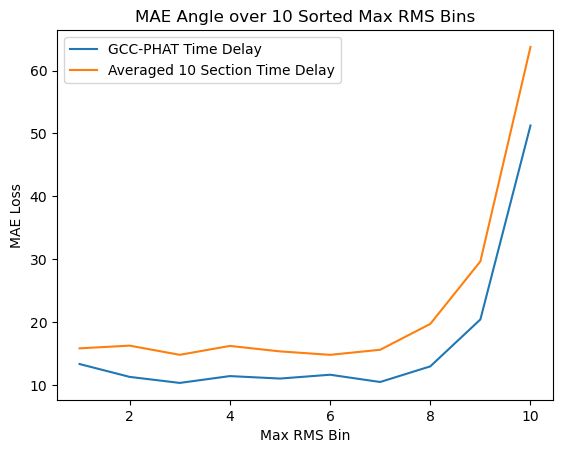

[13.3074, 11.2599, 10.3004, 11.3875, 10.9954, 11.6035, 10.4476, 12.9332, 20.3999, 51.2603]
[15.8048, 16.2319, 14.7731, 16.1879, 15.3181, 14.7693, 15.5784, 19.6884, 29.6471, 63.7665]
[tensor(15.8048), tensor(16.2319), tensor(14.7731), tensor(16.1879), tensor(15.3181), tensor(14.7693), tensor(15.5784), tensor(19.6884), tensor(29.6471), tensor(63.7665)]


In [30]:
wavefroms_list = rms_waveforms.max(axis=2)[0].reshape(-1)
sorted_indexes = torch.argsort(wavefroms_list, descending=True)
len(sorted_indexes)
bin_indexes = [torch.arange(i*2305, (i+1)*2305) for i in range(10)]
mae_percents = []
mae_2 = []
for indexes in bin_indexes:
    print(angles13.reshape(-1)[sorted_indexes[indexes]].mean())
    mae_percents.append(angles13.reshape(-1)[sorted_indexes[indexes]].mean())
    mae_2.append(angles23.reshape(-1)[sorted_indexes[indexes]].mean())
plt.plot(torch.arange(1, 11), mae_percents, label="GCC-PHAT Time Delay")
plt.plot(torch.arange(1, 11), mae_2, label="Averaged 10 Section Time Delay")
plt.legend()
plt.title("MAE Angle over 10 Sorted Max RMS Bins")
plt.xlabel("Max RMS Bin")
plt.ylabel("MAE Loss")
plt.show()
print([round(i.item(), 4) for i in mae_percents])
print([round(i.item(), 4) for i in mae_2])
print(mae_2)

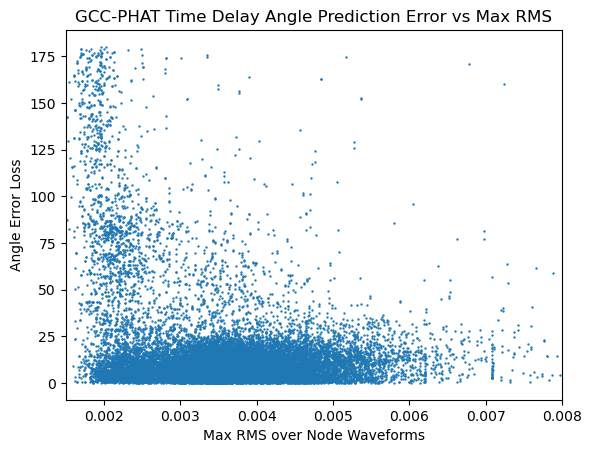

[]

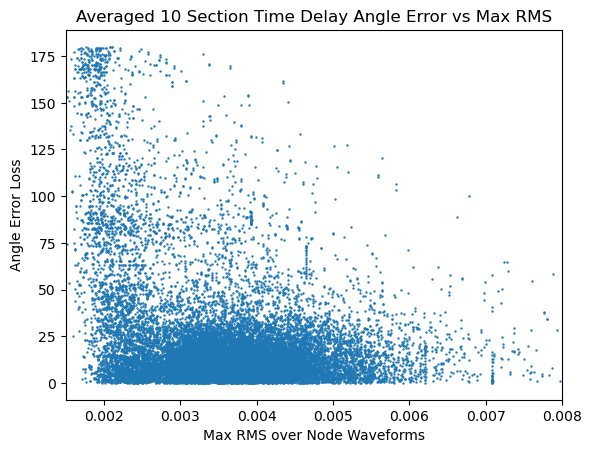

In [27]:
angles13.reshape(-1)
rms_waveforms.mean(axis=2)[0].reshape(-1)

plt.scatter(rms_waveforms.max(axis=2)[0].reshape(-1), angles13.reshape(-1), s=0.5)
plt.xlim(0.0015, 0.008)
plt.xlabel("Max RMS over Node Waveforms")
plt.ylabel("Angle Error Loss")
plt.title("GCC-PHAT Time Delay Angle Prediction Error vs Max RMS")
plt.show()

plt.scatter(rms_waveforms.max(axis=2)[0].reshape(-1), angles23.reshape(-1), s=0.5)
plt.xlim(0.0015, 0.008)
plt.xlabel("Max RMS over Node Waveforms")
plt.ylabel("Angle Error Loss")
plt.title("Averaged 10 Section Time Delay Angle Error vs Max RMS")

plt.plot()

In [107]:
print(angles13.median(), angles13.mean())

tensor(9.3676) tensor(16.4080)


In [106]:
print(angles23.median(), angles23.mean())

tensor(12.6180) tensor(22.1968)


In [118]:
print(angles23.sum(axis=1).median(), angles23.sum(axis=1).mean())
print(angles13.sum(axis=1).median(), angles13.sum(axis=1).mean())

tensor(60.3803) tensor(88.7872)
tensor(42.3029) tensor(65.6319)


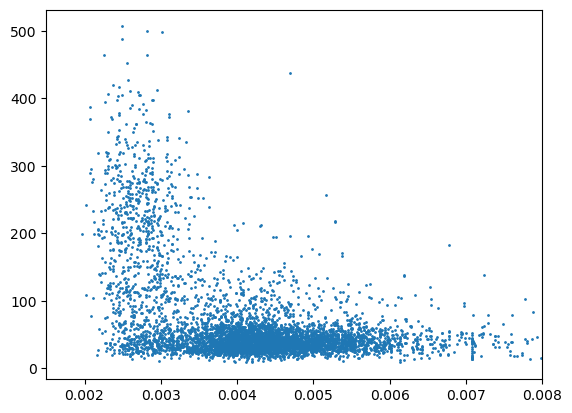

[]

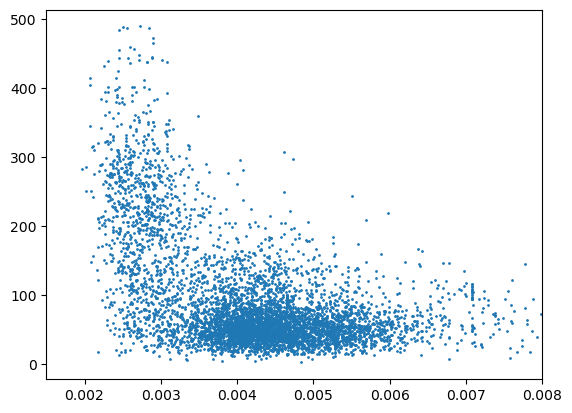

In [114]:
plt.scatter(rms_waveforms.max(axis=2)[0].max(axis=1)[0].reshape(-1), angles13.sum(axis=1), s=1)
plt.xlim(0.0015, 0.008)
plt.show()

plt.scatter(rms_waveforms.max(axis=2)[0].max(axis=1)[0].reshape(-1), angles23.sum(axis=1), s=1)
plt.xlim(0.0015, 0.008)
plt.plot()